# Benchmarking zlib with LossBench

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In this example, we have a file called `jets.root` in the PHYSLITE format. We want to know how the `zlib` compressor performs when compressing jet variables. The `zlib` compressor has a single parameter, `compressionLevel`, which varies from `0` to `9`, where `0` is the lowest amount of compression, and `9` is the highest.

The script `benchmark_zlib.sh` creates a directory to store benchmark outputs, and sets the names of the output files. The file `results.jsonl` contains the results of the benchmark, and is written by `lossbench`. The file `benchmark.log` captures logging statements printed that `lossbench` prints to `stdout`, as well as any error messages sent to `stderr`. 

We then specify which file we want to read from, the name of the tree in that file, and the list of branches we want from that tree.

We use a `for`-loop to vary the `compressionLevel` parameter. In each iteration, we call `lossbench`, passing in the information about what data we want to compress, where we want our results to be written, and the value to use for `compressionLevel`. `lossbench` reads the relevant data out of the given input file (`jets.root`), compresses and decompresses the data with the given compressor (`zlib:compressionLevel=$compressionLevel`), and writes the results to the given output file (`results.jsonl`).

```bash
#!/bin/bash

timestamp=$(date +"%Y%m%d_%H%M%S")

results_dir="results_zlib_$timestamp"
mkdir -p "$results_dir"

results_file="$results_dir/results.jsonl"
log_file="$results_dir/benchmark.log"

# Benchmark parameters
input_file="jets.root"
tree_name="CollectionTree"
branches="AnalysisJetsAuxDyn.pt,AnalysisJetsAuxDyn.eta,AnalysisJetsAuxDyn.phi,AnalysisJetsAuxDyn.m"
chunk_size=32768

# Run benchmark with zlib for varying compression levels
for compression_level in {1..9}
do
    echo "Running benchmark with zlib compression level $compression_level..." >> "$log_file" 2>&1

    ./build/lossbench \
        --inputFile "$input_file" \
        --tree "$tree_name" \
        --branches "$branches" \
        --chunkSize "$chunk_size" \
        --compressor "zlib:compressionLevel=$compression_level" \
        --resultsFile "$results_file" >> "$log_file" 2>&1

    echo "Benchmark with zlib compression level $compression_level completed." >> "$log_file" 2>&1
done
```

At this point, we can analyze our results with any tools that handle the JSON Lines format.

In this example, we load the results into a `pandas` DataFrame. Because each JSON record is nested, we need to normalize the data to get a flat table.

In [44]:
raw = pd.read_json("results.jsonl", lines=True)
df = pd.json_normalize(raw.to_dict(orient="records"), sep=".")
df.head()

,config.branches,config.chunk_size,config.compressor,config.compressor_config.compressionLevel,config.decomp_file,config.input_file,config.results_file,config.tree,results.abs_error_avg,results.abs_error_max,...,results.compression_ratio,results.compression_throughput_mbps,results.decompression_throughput_mbps,results.mse,results.original_size_bytes,results.psnr,results.rel_error_avg,results.rel_error_max,system.host,system.timestamp
0,AnalysisJetsAuxDyn.pt,32768,zlib,1,,jets.root,results_zlib_20251202_192509/results.jsonl,CollectionTree,0.0,0.0,...,1.138389,34.564690,180.837143,0.0,10635492,None,0.0,0.0,Niamh,2025-12-02 19:25:11
1,AnalysisJetsAuxDyn.eta,32768,zlib,1,,jets.root,results_zlib_20251202_192509/results.jsonl,CollectionTree,0.0,0.0,...,1.095449,37.519753,144.024063,0.0,10635492,None,0.0,0.0,Niamh,2025-12-02 19:25:11
2,AnalysisJetsAuxDyn.phi,32768,zlib,1,,jets.root,results_zlib_20251202_192509/results.jsonl,CollectionTree,0.0,0.0,...,1.079120,24.605982,136.021149,0.0,10635492,None,0.0,0.0,Niamh,2025-12-02 19:25:12
3,AnalysisJetsAuxDyn.m,32768,zlib,1,,jets.root,results_zlib_20251202_192509/results.jsonl,CollectionTree,0.0,0.0,...,1.138117,33.853443,95.954903,0.0,10635492,None,0.0,0.0,Niamh,2025-12-02 19:25:13
4,AnalysisJetsAuxDyn.pt,32768,zlib,2,,jets.root,results_zlib_20251202_192509/results.jsonl,CollectionTree,0.0,0.0,...,1.139075,33.037060,174.190613,0.0,10635492,None,0.0,0.0,Niamh,2025-12-02 19:25:14


Now we use `matplotlib` and `seaborn` to plot some of our results. 

Plotting compression ratio vs compression level shows us that, for this data, using a compression level higher than `4` does not result in better compression. We can also see that some variables (`.pt`, `.m`) seem to compress better than others, on average (`.eta`, `.phi`).

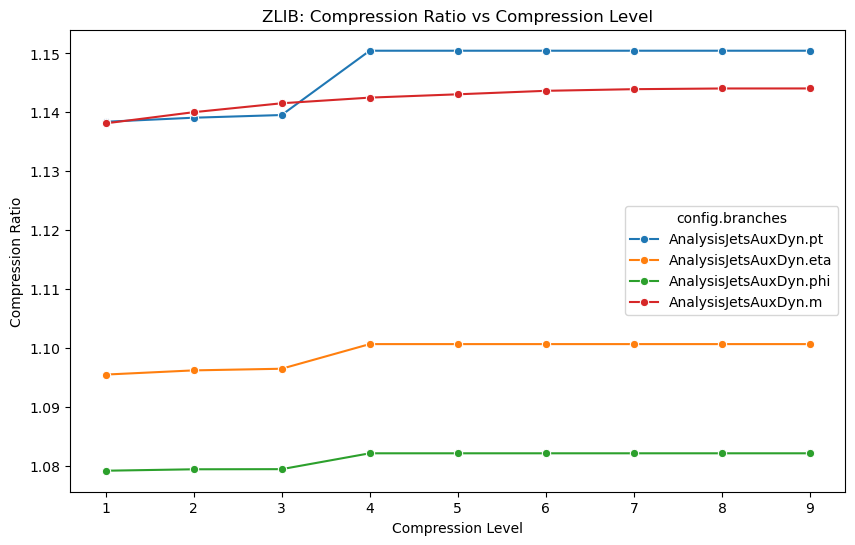

In [45]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df, 
    x="config.compressor_config.compressionLevel", 
    y="results.compression_ratio", 
    marker="o",
    hue="config.branches",
)

plt.xlabel("Compression Level")
plt.ylabel("Compression Ratio")
plt.title("ZLIB: Compression Ratio vs Compression Level")
plt.show()